In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
#import h5py
import sys
import os
import pyflct
from scipy.stats import pearsonr

# We need this to navigate through our data
import muram 

# Input/output
from astropy.io import fits

In [2]:
# We should import all tau_slices at Tau = 1 and see how flow tracking behaves for this data
# Initializing list of names of all the files
filenames = []

# Retreiving only numerical files
for file in sorted(os.listdir (os.getcwd())):
	if file.startswith("tau_slice"):
		#print (file)
		filenames.append(file)
print ("How many files are in directory: {}".format(len(filenames)))

# Setting the new array length as the number of tau slices
NT = len(filenames) # timeseries

iter = 50
level = 1.0
tempfile = muram.MuramTauSlice('', iter, level)
# Let's print the shape of our file(s):
print(np.shape(tempfile))

NP, NX, NY = np.shape(tempfile) # parameters, x, y
#T_series = np.zeros([NX, NY])
T_array = []
Bz_array = []
Vx_array = []
Vy_array = []
I_continuum = []
# To make sure we are using the temperature
#plt.imshow(tempfile[8].T, origin='lower',vmin=5500,vmax=8000)

# Looping through all the slices
test_range = 5
for iter in range(test_range):
    test = filenames[iter]
    data_full = np.fromfile(test, dtype="float32")
    data = data_full[4:].reshape(11, 1536, 1536)
    T = data[8,:,:]
    Bz = data[7,:,:]
    Vx = data[1,:,:]
    Vy = data[2,:,:]
    #Int = muram.MuramIntensity('',iter)
    Vx_array.append(Vx)
    Vy_array.append(Vy)
    T_array.append(T)
    Bz_array.append(Bz)
    #I_continuum.append(Int)
	
	
# Kada se traze brzine, pre nego sto se trazi korelacija, nadjimo nacin da vizualizujemo ono sto dobijamo
# i vidimo da kakve su mape brzine, da li su granule ok itd.

# For easier further use we will write the data out in a fits file
# that shall be available to users

I_out_filenames = []
for file in sorted(os.listdir (os.getcwd())):
	if file.startswith("I_out"):
		#print (file)
		I_out_filenames.append(file)
print ("How many files are in directory: {}".format(len(I_out_filenames)))

# WIP
iter = 50
I_out_filenames = ["I_out.000000", "I_out.000050", "I_out.000100", "I_out.000150", "I_out.000200"]
for iter in range(len(I_out_filenames)):
    name = I_out_filenames[iter]
    new_name = name.split(".")
    #print(new_name)
    if(int(new_name[1])%50 == 0):
        Int = muram.MuramIntensity('',int(new_name[1]))
        I_continuum.append(Int)



T_array = np.asarray(T_array)
Bz_array = np.asarray(Bz_array)
Vx_array = np.asarray(Vx_array)
Vy_array = np.asarray(Vy_array)
I_continuum = np.asarray(I_continuum)

Temp = fits.PrimaryHDU(T_array)
Bz = fits.ImageHDU(Bz_array)
Vx = fits.ImageHDU(Vx_array)
Vy = fits.ImageHDU(Vy_array)
I500 = fits.ImageHDU(I_continuum)
data_out = fits.HDUList([Temp, Bz, Vx, Vy, I500])

# Write the fits file
data_out.writeto("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits", overwrite = True)

How many files are in directory: 295
(11, 1536, 1536)
How many files are in directory: 361


In [3]:
Temp = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[0].data
Bz = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[1].data
Vx = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[2].data
Vy = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[3].data
I500 = fits.open("ISSI_2D_Tau=1.0-" + str(test_range) + "slices.fits")[4].data

In [4]:
# Let's do basic comparison of "real" velocities and the ones that FLCT gives
# between every 2 adjacent files 

# Good time intervals somewhat connected to observations
 # 30s, 60s, 360s, 
# FWHM
 # 1200, 2400, 100, 200, 600
# 50 km = 1 pixel for Gregor

FWHM = 1000 # km
delta_t = 10 # sec
pixelsize = 16 #
sigma_pyflct = FWHM/2.35/pixelsize
print(sigma_pyflct)

26.595744680851062


In [5]:
Vx_mean = []
Vy_mean = []
for j in range(1, len(Vx)):
    vx = (Vx[j-1] + Vx[j])/2/1e5
    Vx_mean.append(vx)
    vy = (Vy[j-1] + Vy[j])/2/1e5
    Vy_mean.append(vy)

In [6]:
# Now, we implement FLCT on our Temp array
Vel_x_T = []
Vel_y_T = []
Vm_T = []
for j in range(1, len(Temp)):
    vel_x, vel_y, vm = pyflct.flct(Temp[j-1], Temp[j], delta_t, pixelsize, sigma_pyflct)
    Vel_x_T.append(vel_x)
    Vel_y_T.append(vel_y)
    Vm_T.append(vm)

print("Length of Vel_x_T: {}".format(len(Vel_x_T)))

flct: nominal sliding box size = 108
flct: mean value of gamma^2/sigma^2 = 0.0594903ut of 1535

flct: finished
flct: nominal sliding box size = 108
flct: mean value of gamma^2/sigma^2 = 0.0596947

flct: finished
flct: nominal sliding box size = 108
flct: mean value of gamma^2/sigma^2 = 0.0595906

flct: finished
flct: nominal sliding box size = 108
flct: progress  i Length of Vel_x_T: 4
flct: mean value of gamma^2/sigma^2 = 0.05932585 out of 1535ct: progress  i = 1084 out of 1535

flct: finished


In [56]:
#Now for Bz array
Vel_x_Bz = []
Vel_y_Bz = []
Vm_Bz = []
for j in range(1, len(Bz)):
    vel_x, vel_y, vm = pyflct.flct(Bz[j-1], Bz[j], delta_t, pixelsize, sigma_pyflct)
    Vel_x_Bz.append(vel_x)
    Vel_y_Bz.append(vel_y)
    Vm_Bz.append(vm)

print("Length of Vel_x_Bz: {}".format(len(Vel_x_Bz)))

flct: nominal sliding box size = 20
flct: mean value of gamma^2/sigma^2 = 0.194972

flct: finished
flct: nominal sliding box size = 20
flct: mean value of gamma^2/sigma^2 = 0.194275

flct: finished
flct: nominal sliding box size = 20
flct: mean value of gamma^2/sigma^2 = 0.193866

flct: finished
flct: nominal sliding box size = 20
Length of Vel_x_Bz: 4
flct: mean value of gamma^2/sigma^2 = 0.194146

flct: finished


In [7]:
#Now for continuum instensity array
Vel_x_I = []
Vel_y_I = []
Vm_I = []
for j in range(1, len(I500)):
    vel_x, vel_y, vm = pyflct.flct(I500[j-1], I500[j], delta_t, pixelsize, sigma_pyflct)
    Vel_x_I.append(vel_x)
    Vel_y_I.append(vel_y)
    Vm_I.append(vm)

print("Length of Vel_x_I: {}".format(len(Vel_x_I)))

flct: nominal sliding box size = 108
flct: mean value of gamma^2/sigma^2 = 0.0935644

flct: finished
flct: nominal sliding box size = 108
flct: mean value of gamma^2/sigma^2 = 0.0934516

flct: finished
flct: nominal sliding box size = 108
flct: mean value of gamma^2/sigma^2 = 0.0933266

flct: finished
flct: nominal sliding box size = 108
Length of Vel_x_I: 4
flct: mean value of gamma^2/sigma^2 = 0.0932083

flct: finished


In [8]:
Vel_x_I = np.asarray(Vel_x_I)
Vel_y_I = np.asarray(Vel_y_I)
Vm_I = np.asarray(Vm_I)

In [9]:
# And we can finally write them each to separate fits files
Vel_x_T = np.asarray(Vel_x_T)
Vel_y_T = np.asarray(Vel_y_T)
Vm_T = np.asarray(Vm_T)

In [47]:
T_x = fits.PrimaryHDU(Vel_x_T)
T_y = fits.ImageHDU(Vel_y_T)
T_v = fits.ImageHDU(Vm_T)
T_flct = fits.HDUList([T_x, T_y, T_v])
T_flct.writeto("ISSI_FLCT_temperature.fits", overwrite = True)

In [18]:
# Intensity 
I_x = fits.PrimaryHDU(Vel_x_I)
I_y = fits.ImageHDU(Vel_y_I)
I_v = fits.ImageHDU(Vm_I)
I_flct = fits.HDUList([I_x, I_y, I_v])
I_flct.writeto("ISSI_FLCT_intensity.fits", overwrite = True)

In [19]:
# FLTC-derived velocities based on intensity 
Vel_x_I = fits.open("ISSI_FLCT_intensity.fits")[0].data
Vel_y_I = fits.open("ISSI_FLCT_intensity.fits")[1].data
Vm_I = fits.open("ISSI_FLCT_intensity.fits")[2].data

In [10]:
# FLTC-derived velocities based on temperature
Vel_x_T = fits.open("ISSI_FLCT_temperature.fits")[0].data
Vel_y_T = fits.open("ISSI_FLCT_temperature.fits")[1].data
Vm_T = fits.open("ISSI_FLCT_temperature.fits")[2].data

In [10]:
# Averaged, i.e mean Vx and Vy
Vx_mean = []
Vy_mean = []
for j in range(1, len(Vx)):
    vx = (Vx[j-1] + Vx[j])/2/1e5
    Vx_mean.append(vx)
    vy = (Vy[j-1] + Vy[j])/2/1e5
    Vy_mean.append(vy)

Vx_mean = np.asarray(Vx_mean)
Vy_mean = np.asarray(Vy_mean)

In [13]:
# Pearson's correlation coefficients
px_1 = []
py_1 = []

# This is for show only
# It will be updated to run more smoothly

for j in range(1, len(Vel_x_T)):
    p_x = pearsonr(Vx_mean[j-1].flatten(), Vel_x_T[j-1].flatten())
    px_1.append(p_x)
    p_y = pearsonr(Vy_mean[j-1].flatten(), Vel_y_T[j-1].flatten())
    py_1.append(p_y)
    print("Pearson for x:{}".format(p_x))
    print("Pearson for y:{}".format(p_y))

Pearson for x:PearsonRResult(statistic=-0.00019815007275965574, pvalue=0.760854892721977)
Pearson for y:PearsonRResult(statistic=-0.023474028142590787, pvalue=9.254199302201893e-285)


/tmp/ipykernel_7047/1752492083.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Vx_mean, Vel_x_T, s=25, cmap=plt.cm.coolwarm, zorder=10)


(-660.6423665005416, 1725.7329968066006)

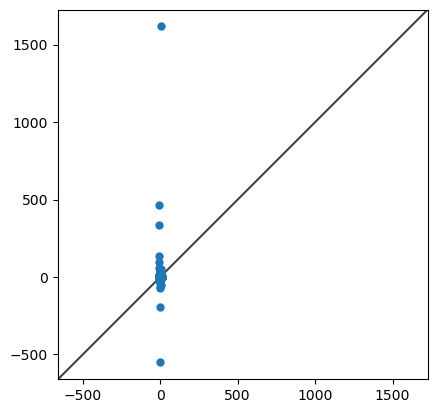

In [14]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(Vx_mean, Vel_x_T, s=25, cmap=plt.cm.coolwarm, zorder=10)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

<p style="color:black;font-family:Sans-serif">
    This is preliminary plot showing the correlation between mean x-component of velocity and x-component of
    velocity that is result of Fourier Local Correlation Tracking based on the temperature provided in simulations.
    The example in question was aranged upon just 4 slices at $\tau$ = 1, as an indicator of what to expect.
</p>

In [56]:
Vel_x_T.shape

(2, 1536, 1536)

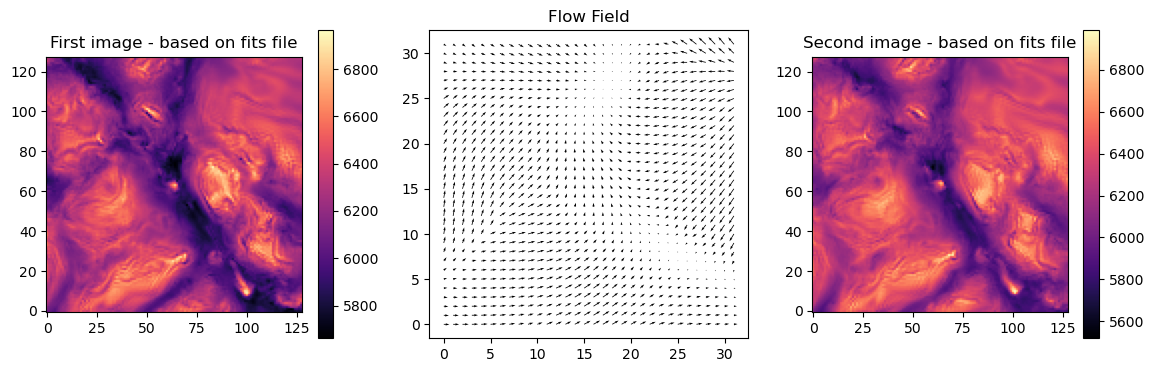

In [65]:
image1 = Temp[0]
image2 = Temp[1]
i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted - prvi pokusaj
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)

# Plotting the first image
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
plt.imshow(image1[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
plt.colorbar()
ax1.set_title("First image - based on fits file")

# Plot the 2D flow field
ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vel_x_T[0,i_start:i_end:4, j_start:j_end:4], Vel_y_T[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field") #FLCT

# Plot the shifted image
ax3 = fig.add_subplot(133)
plt.imshow(image2[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
ax3.set_title("Second image - based on fits file")
plt.colorbar()

In [27]:
cdata = data_full[4:].reshape(11, 1536, 1536)


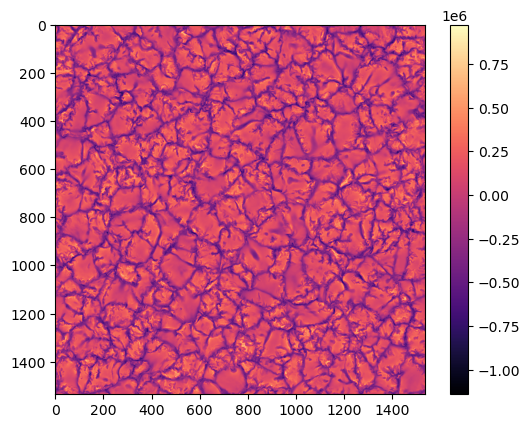

In [48]:
cube = data[1]
B_unit=np.sqrt(4*np.pi)
plt.imshow(cube, cmap = 'magma')
plt.colorbar()

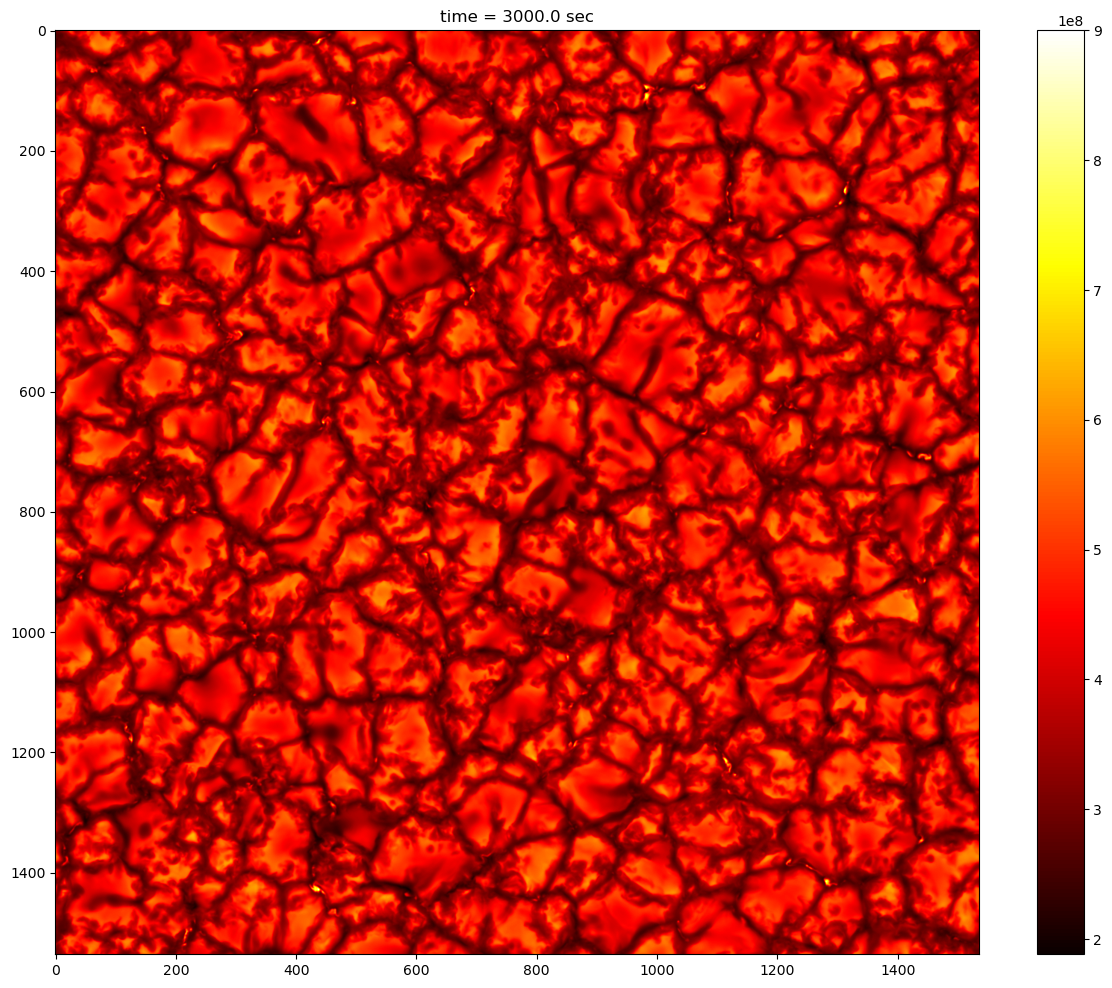

In [7]:
iter1=15000

Int=muram.MuramIntensity('',iter1)
plt.figure(figsize=(15,12))
plt.imshow(Int,cmap='hot')
plt.title(f"time = {Int.time} sec")
plt.colorbar()
plt.show()

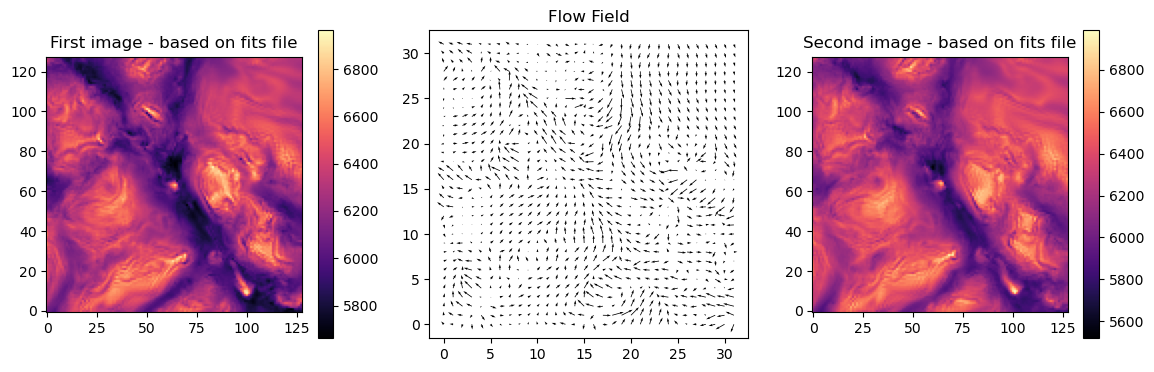

In [66]:
image1 = Temp[0]
image2 = Temp[1]
i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted - prvi pokusaj
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)

# Plotting the first image
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
plt.imshow(image1[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
plt.colorbar()
ax1.set_title("First image - based on fits file")

# Plot the 2D flow field
ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field") #FLCT

# Plot the shifted image
ax3 = fig.add_subplot(133)
plt.imshow(image2[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
ax3.set_title("Second image - based on fits file")
plt.colorbar()

NameError: name 'U' is not defined

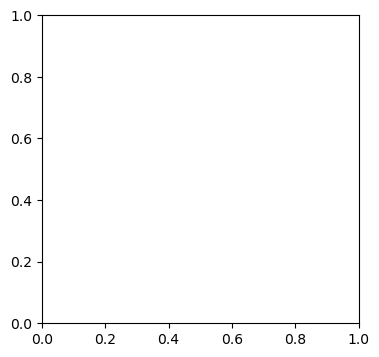

In [10]:
# Plotting the first image
fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_subplot(121)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field based on mean velocity from simulation") 

ax2 = fig.add_subplot(122)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_T[0,i_start:i_end:4, j_start:j_end:4], Vel_y_T[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field based on FLCT") 


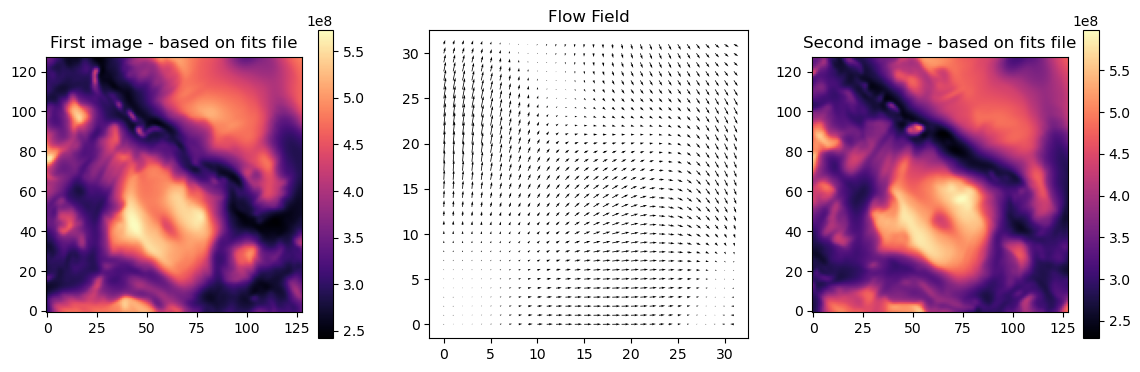

In [24]:
# Trying out intensity as windowing parameter

image1 = I500[0]
image2 = I500[4]
i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted - prvi pokusaj
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)

# Plotting the first image
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
plt.imshow(image1[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
plt.colorbar()
ax1.set_title("First image - based on fits file")

# Plot the 2D flow field
ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field") #FLCT

# Plot the shifted image
ax3 = fig.add_subplot(133)
plt.imshow(image2[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
ax3.set_title("Second image - based on fits file")
plt.colorbar()

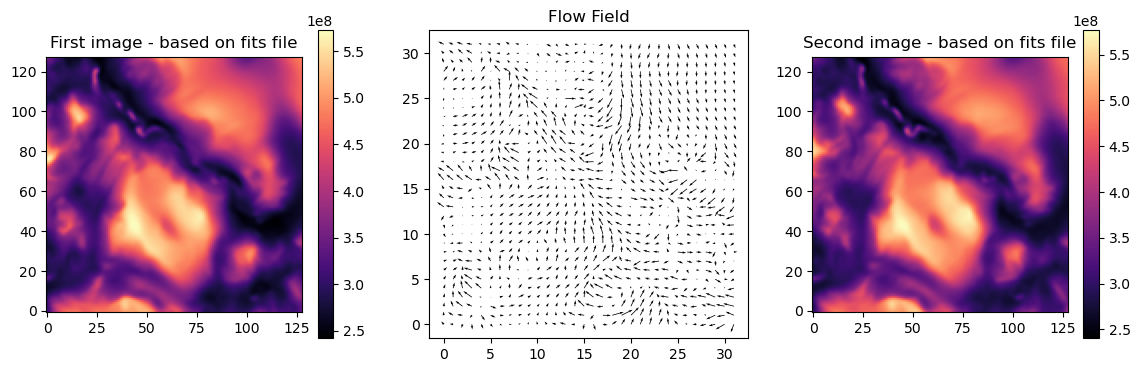

In [22]:
image1 = I500[0]
image2 = I500[4]
i_start = 0
j_start = 0
i_end = 128
j_end = 128
# But first we need to create a meshgrid on which the flow field will be plotted - prvi pokusaj
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)

# Plotting the first image
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(131)
plt.imshow(image1[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
plt.colorbar()
ax1.set_title("First image - based on fits file")

# Plot the 2D flow field
ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - ") #FLCT

# Plot the shifted image
ax3 = fig.add_subplot(133)
plt.imshow(image2[i_start:i_end, j_start:j_end], origin="lower", cmap='magma')
ax3.set_title("Second image - based on fits file")
plt.colorbar()

Text(0.5, 1.0, 'Flow Field - FLCT; continuum intensity windowing parameter')

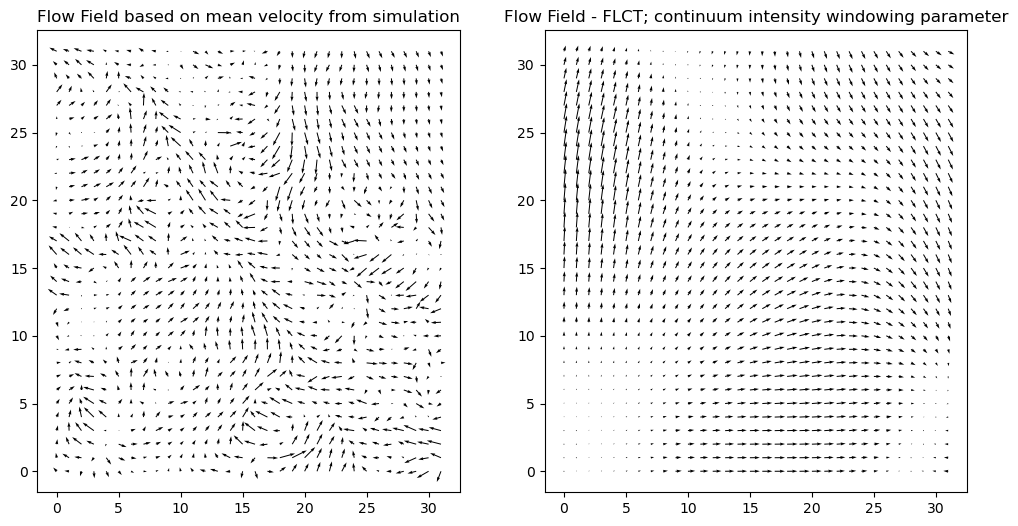

In [32]:
# Plotting the first image
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field based on mean velocity from simulation") 

ax2 = fig.add_subplot(122)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; continuum intensity windowing parameter") 

In [28]:
print(Vel_x_I)

[[[0.09742031 0.10040433 0.1037394  ... 0.35516155 0.34554816 0.33627209]
  [0.09401456 0.09698816 0.10031446 ... 0.3492056  0.33976542 0.33065844]
  [0.09055072 0.09351007 0.09682356 ... 0.3430759  0.33381281 0.32487882]
  ...
  [0.20467505 0.21217771 0.2201565  ... 0.49073552 0.47724518 0.46432961]
  [0.20418124 0.21159027 0.21947173 ... 0.4962073  0.48261628 0.46960418]
  [0.20332403 0.21062709 0.21839834 ... 0.50142392 0.48773797 0.47463485]]

 [[0.13167976 0.1337749  0.13604253 ... 0.29598017 0.28697016 0.27835141]
  [0.12845498 0.13050122 0.13271731 ... 0.29079473 0.2818942  0.27338203]
  [0.12513391 0.12712622 0.12928537 ... 0.28539653 0.27660974 0.26820849]
  ...
  [0.21067339 0.218021   0.22581811 ... 0.35220614 0.34180286 0.33190192]
  [0.21056998 0.21782997 0.22553449 ... 0.35228479 0.34190111 0.33202445]
  [0.21015869 0.21731987 0.22492002 ... 0.35227629 0.34191724 0.33206957]]

 [[0.07810531 0.07986744 0.08182206 ... 0.25274453 0.2440289  0.23579737]
  [0.076166   0.077902

In [40]:
sigma_pyflct

31.914893617021274

Text(0.5, 1.0, 'Flow Field - FLCT; temperature is windowing parameter')

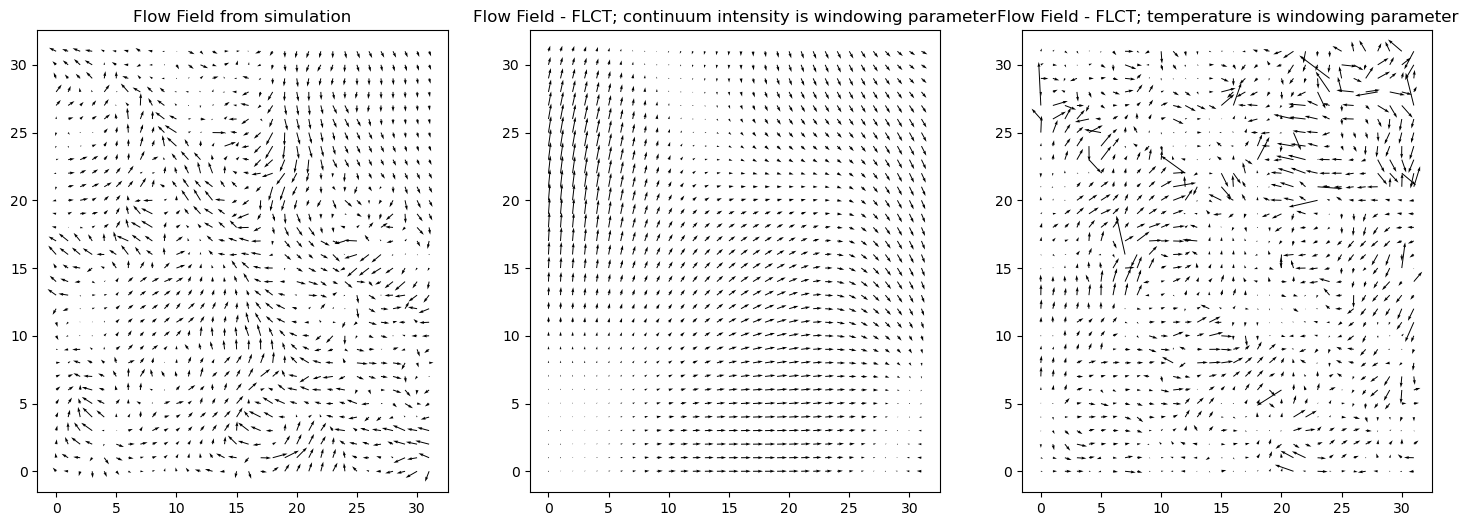

In [55]:
# Plotting the first image
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field from simulation") 

ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; continuum intensity is windowing parameter") 

ax3 = fig.add_subplot(133)
ax3.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_T[0,i_start:i_end:4, j_start:j_end:4], Vel_y_T[0,i_start:i_end:4, j_start:j_end:4])
ax3.set_title("Flow Field - FLCT; temperature is windowing parameter") 

Text(0.5, 1.0, 'Flow Field - FLCT; temperature is windowing parameter')

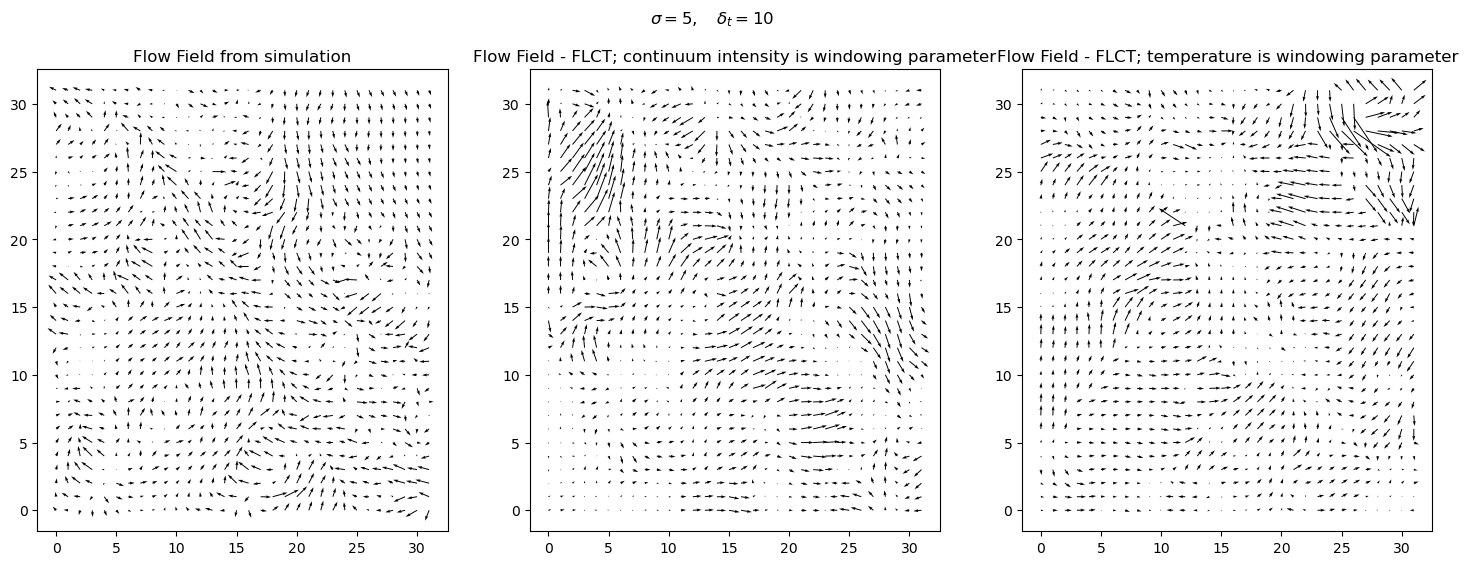

In [72]:
# Plotting the first image
fig = plt.figure(figsize=(18, 6))
fig.suptitle('$\sigma = 5, \quad \Delta_t=10$')
ax1 = fig.add_subplot(131)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field from simulation") 

ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; continuum intensity is windowing parameter") 

ax3 = fig.add_subplot(133)
ax3.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_T[0,i_start:i_end:4, j_start:j_end:4], Vel_y_T[0,i_start:i_end:4, j_start:j_end:4])
ax3.set_title("Flow Field - FLCT; temperature is windowing parameter") 

Text(0.5, 1.0, 'Flow Field - FLCT; temperature is windowing parameter')

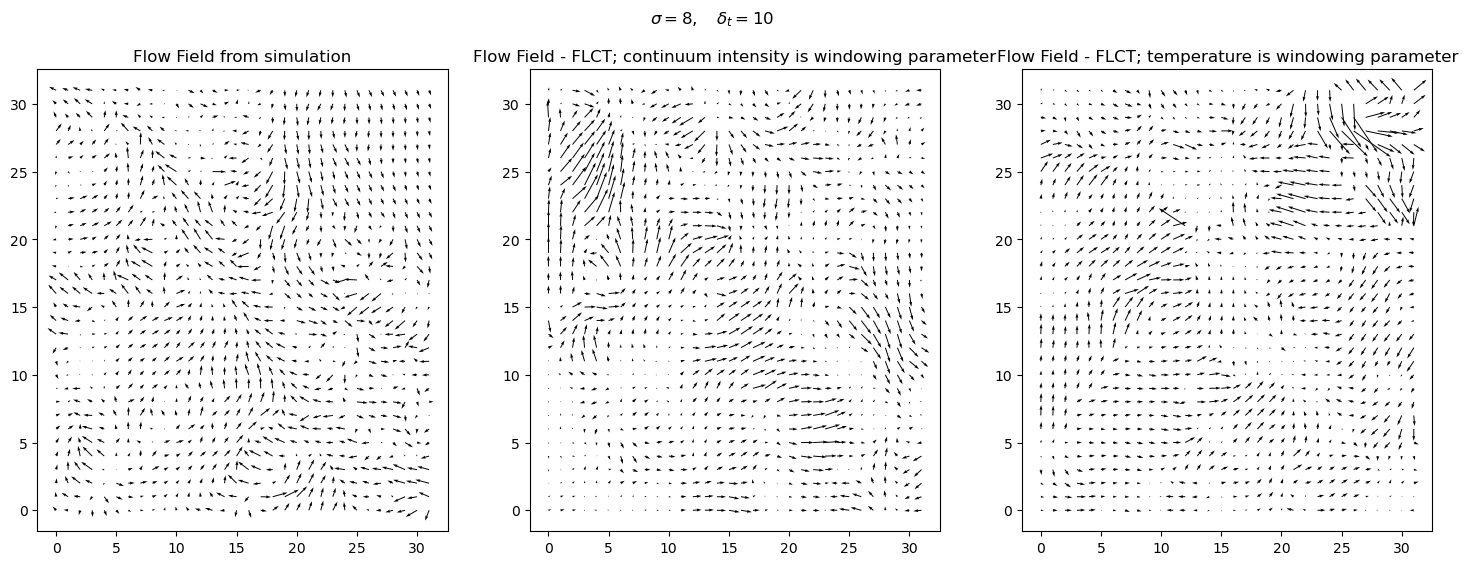

In [73]:
# Plotting the first image
fig = plt.figure(figsize=(18, 6))
fig.suptitle('$\sigma = 8, \quad \Delta_t=10$')
ax1 = fig.add_subplot(131)
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field from simulation") 

ax2 = fig.add_subplot(132)
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; continuum intensity is windowing parameter") 

ax3 = fig.add_subplot(133)
ax3.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_T[0,i_start:i_end:4, j_start:j_end:4], Vel_y_T[0,i_start:i_end:4, j_start:j_end:4])
ax3.set_title("Flow Field - FLCT; temperature is windowing parameter") 

Text(0.5, 1.0, 'Flow Field - FLCT; temperature windowing parameter')

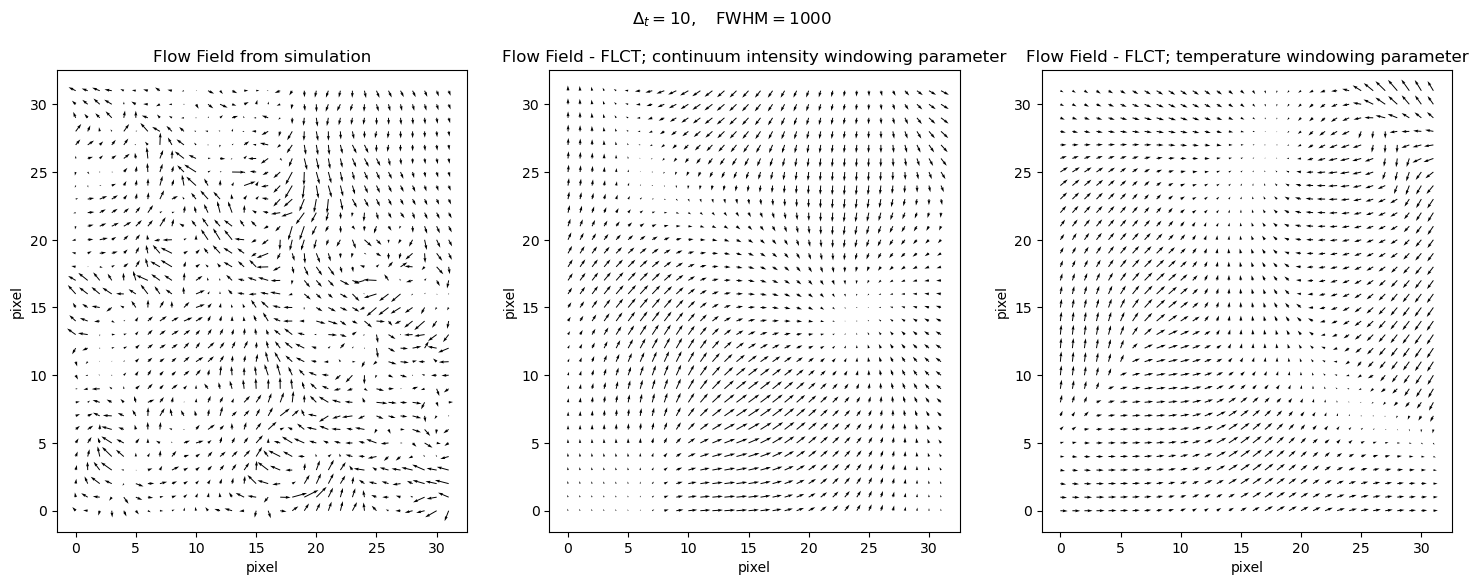

In [26]:
# But first we need to create a meshgrid on which the flow field will be plotted - prvi pokusaj
X = np.arange(0, 32, 1)
Y = np.arange(0, 32, 1)
U, V = np.meshgrid(X, Y)
i_start = 0
j_start = 0
i_end = 128
j_end = 128

# Plotting the first image
fig = plt.figure(figsize=(18, 6))
fig.suptitle(r'$\Delta_t=10, \quad \mathrm{FWHM}=1000$')
ax1 = fig.add_subplot(131)
ax1.set_xlabel("pixel")
ax1.set_ylabel("pixel")
ax1.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
           Vx_mean[0,i_start:i_end:4, j_start:j_end:4], Vy_mean[0,i_start:i_end:4, j_start:j_end:4])
ax1.set_title("Flow Field from simulation") 

ax2 = fig.add_subplot(132)
ax2.set_xlabel("pixel")
ax2.set_ylabel("pixel")
ax2.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_I[0,i_start:i_end:4, j_start:j_end:4], Vel_y_I[0,i_start:i_end:4, j_start:j_end:4])
ax2.set_title("Flow Field - FLCT; continuum intensity windowing parameter") 

ax3 = fig.add_subplot(133)
ax3.set_xlabel("pixel")
ax3.set_ylabel("pixel")
ax3.quiver(U[i_start:i_end, j_start:j_end], V[i_start:i_end, j_start:j_end], \
          Vel_x_T[0,i_start:i_end:4, j_start:j_end:4], Vel_y_T[0,i_start:i_end:4, j_start:j_end:4])
ax3.set_title("Flow Field - FLCT; temperature windowing parameter") 

<p>
    When the raw data is compared against pyFLCT derived data, the correlation is low. Spatial averaging (binning) is recommended.
</p>